In [71]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [72]:
matplotlib.rcParams['figure.figsize'] = (5.0, 4.0)

In [73]:
from Preprocessor import Preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *

In [74]:
import scipy

In [75]:
def read_affine(string, scale):
    a = np.reshape(np.array([float(i) for i in string.split()]), (4,4))
    a[:3,3] /= scale
    return a

In [76]:
def fid_apply_affine(fids, affine):
    return np.array([affine.dot(i) for i in fids])[:,:3]

### Step 1: Load data

In [7]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/average_template_50.tif')

In [8]:
atlas.SetSpacing((0.05, 0.05, 0.05))

## load fiducials

In [20]:
r = Registerer(atlas, img, "ASR", "LPS")

In [21]:
afid = r._parse_fiducial_file('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 0.01/10.0)
rfid = r._parse_fiducial_file('../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 0.00516/1.0)

### set some constants

In [11]:
true_spacing_atlas = [13.200, 8.000, 11.400] # mm
true_spacing_raw = [13.20096, 7.3530, 11.1456] # mm
center_raw = np.array(true_spacing_raw)/2.0 # mm
center_atlas = np.array(true_spacing_atlas)/2.0 # mm
raw_fid_o = "LPI"
atlas_fid_o = "PIR"
pad = 20 # voxel padding for phis, phiinvs, and x,y,z

In [12]:
# read inv displacement fields
phiinvx = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phiinvx.img')[pad:-pad, pad:-pad, pad:-pad]
phiinvy = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phiinvy.img')[pad:-pad, pad:-pad, pad:-pad]
phiinvz = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phiinvz.img')[pad:-pad, pad:-pad, pad:-pad]

In [13]:
# read inv displacement fields
phix = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phix.img')[pad:-pad, pad:-pad, pad:-pad]
phiy = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phiy.img')[pad:-pad, pad:-pad, pad:-pad]
phiz = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/phiz.img')[pad:-pad, pad:-pad, pad:-pad]

In [14]:
# read grids
x = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/x.img')[pad:-pad, pad:-pad, pad:-pad]
y = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/y.img')[pad:-pad, pad:-pad, pad:-pad]
z = ndreg.imgRead('../ndreg/control9_for_vikram_nov_12/z.img')[pad:-pad, pad:-pad, pad:-pad]

In [15]:
t2a_s = """0.986066 -0.094286 0.024768 516.012050
0.089707 0.992495 -0.013788 -443.893828
-0.009284 0.016666 0.950780 190.920903
0.000000 0.000000 0.000000 1.000000
"""
a2t_s = """1.005173 0.095907 -0.024794 -471.375106
-0.090695 0.998663 0.016845 486.883867
0.011405 -0.016569 1.051231 -213.941982
0.000000 0.000000 0.000000 1.000000
"""

In [16]:
t2a = read_affine(t2a_s, 1000.0)
a2t = read_affine(a2t_s, 1000.0)

In [17]:
phix_np = sitk.GetArrayViewFromImage(phix)
phiy_np = sitk.GetArrayViewFromImage(phiy)
phiz_np = sitk.GetArrayViewFromImage(phiz)
phiinvx_np = sitk.GetArrayViewFromImage(phiinvx)
phiinvy_np = sitk.GetArrayViewFromImage(phiinvy)
phiinvz_np = sitk.GetArrayViewFromImage(phiinvz)

In [18]:
phi = np.zeros(phix_np.shape + (3,))
phiinv = np.zeros(phix_np.shape + (3,))

In [19]:
phi[:,:,:,0] = phix_np /1000.0
phi[:,:,:,1] = phiy_np /1000.0
phi[:,:,:,2] = phiz_np /1000.0
phiinv[:,:,:,0] = phiinvx_np /1000.0
phiinv[:,:,:,1] = phiinvy_np /1000.0
phiinv[:,:,:,2] = phiinvz_np /1000.0

# now reorient fiducials

In [22]:
rfid = r._reorient_landmarks(rfid, raw_fid_o, atlas_fid_o, center_raw[[2,0,1]])

In [23]:
rfid[-1]

array([  8.0193108 ,   3.24898884,  10.92140471])

In [24]:
afid[-1]

array([  8.27661,   3.43059,  10.8336 ])

In [25]:
afid_c = afid - center_atlas
rfid_c = rfid - center_raw

In [26]:
afid_c[-1]

array([ 1.67661, -0.56941,  5.1336 ])

In [27]:
rfid_c[-1]

array([ 1.4188308 , -0.42751116,  5.34860471])

In [28]:
rfid_ch = np.append(rfid_c, np.zeros((rfid_c.shape[0],1)), axis=1)

In [29]:
np.mean(r._compute_error(afid_c, rfid_c))

0.8540059489259354

In [30]:
rfid_af1 = fid_apply_affine(rfid_ch, t2a)
rfid_af2 = fid_apply_affine(rfid_ch, a2t)

In [31]:
rfid_af1[-1]

array([ 1.57184337, -0.3707702 ,  5.06504906])

In [32]:
rfid_af2[-1]

array([ 1.25255579, -0.46552319,  5.64588427])

In [33]:
np.mean(r._compute_error(afid_c, rfid_af1))

0.79092120083557893

In [34]:
np.mean(r._compute_error(afid_c, rfid_af2))

1.0485477475090663

In [35]:
xyz = np.zeros(phix_np.shape + (3,))

In [36]:
xyz[:,:,:,0] = sitk.GetArrayViewFromImage(x) /1000.0
xyz[:,:,:,1] = sitk.GetArrayViewFromImage(y) /1000.0
xyz[:,:,:,2] = sitk.GetArrayViewFromImage(z) /1000.0

In [37]:
xmin = xyz[:,:,:,0].min()
xmax = xyz[:,:,:,0].max()
ymin = xyz[:,:,:,1].min()
ymax = xyz[:,:,:,1].max()
zmin = xyz[:,:,:,2].min()
zmax = xyz[:,:,:,2].max()

In [38]:
max_vals = np.array([xmax, ymax, zmax])
min_vals = np.array([xmin, ymin, zmin])

In [39]:
# afid_rescaled = (afid / true_spacing_atlas) * (max_vals - min_vals) + min_vals

In [40]:
afid_c[-5]

array([ 5.2173 , -1.44407, -2.11509])

In [41]:
x_i = xyz[0,:,0,0]
y_i = xyz[0,0,:,1]
z_i = xyz[:,0,0,2]

In [42]:
xmax

6.5749998092651367

In [43]:
zmax

5.6750001907348633

In [44]:
ymax

3.9749999046325684

In [45]:
len(x_i)

264

In [46]:
len(y_i)

160

In [47]:
len(z_i)

228

In [48]:
afid_c[:,[2, 0, 1]][-5]

array([-2.11509,  5.2173 , -1.44407])

In [49]:
afid_lddmm_x = scipy.interpolate.interpn((z_i, x_i, y_i), phi[:,:,:,0], afid_c[:,[2, 0, 1]])
afid_lddmm_y = scipy.interpolate.interpn((z_i, x_i, y_i), phi[:,:,:,1], afid_c[:,[2, 0, 1]])
afid_lddmm_z = scipy.interpolate.interpn((z_i, x_i, y_i), phi[:,:,:,2], afid_c[:,[2, 0, 1]])

In [50]:
afid_lddmm = np.array([[i, j, k] for i,j,k in zip(afid_lddmm_x, afid_lddmm_y, afid_lddmm_z)])

In [51]:
# afid_lddmm *= true_spacing_atlas

In [52]:
afid_lddmm[-5] 

array([ 5.4309256 , -1.24993638, -2.09522695])

In [53]:
rfid_af1[-5]

array([ 4.95742864, -1.04763828, -2.03699754])

In [54]:
rfid_af2[-5]

array([ 4.86312663, -2.01034991, -2.09175984])

In [55]:
np.mean(r._compute_error(rfid_af1, afid_lddmm))

0.77862897279186738

In [56]:
np.mean(r._compute_error(rfid_af2, afid_lddmm))

0.9721113650296066

In [57]:
afid_lddmm_h = np.append(afid_lddmm, np.zeros((afid_lddmm.shape[0],1)), axis=1)

In [58]:
afid_lddmm_h[-5]

array([ 5.4309256 , -1.24993638, -2.09522695,  0.        ])

In [59]:
afid_lddmm_af1 = fid_apply_affine(afid_lddmm_h, t2a)
afid_lddmm_af2 = fid_apply_affine(afid_lddmm_h, a2t)

In [60]:
afid_lddmm_af1[-5]

array([ 5.421208  , -0.72447457, -2.06335203])

In [61]:
afid_lddmm_af2[-5]

array([ 5.39109119, -1.77611711, -2.11991762])

In [66]:
afid_lddmm_af1_rr = afid_lddmm_af1 + center_raw
afid_lddmm_af2_rr = afid_lddmm_af2 + center_raw

In [67]:
afid_lddmm_af1_rr[-5]

array([ 12.021688  ,   2.95202543,   3.50944797])

In [68]:
afid_lddmm_af2_rr[-5]

array([ 11.99157119,   1.90038289,   3.45288238])

In [69]:
rfid[-5]

array([ 11.5335804 ,   2.14633812,   3.5053428 ])

In [70]:
np.mean(r._compute_error(rfid, afid_lddmm_af2_rr))

0.7941452066290251

In [83]:
np.mean(r._compute_error(rfid_c, afid_lddmm_af2))

0.7941452066290251

In [30]:
def plot_landmark_ortho(img, pt, refThreshold):
    test_img = sitk.GetArrayViewFromImage(img[:,:,pt[2]]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[0], pt[1], 'ro')
    plt.colorbar()
    plt.show()
    test_img = sitk.GetArrayViewFromImage(img[:,pt[1],:]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[0], pt[2], 'ro')
    plt.colorbar()
    plt.show()
    test_img = sitk.GetArrayViewFromImage(img[pt[0],:,:]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[1], pt[2], 'ro')
    plt.colorbar()
    plt.show()

In [192]:
pt = afid[-1]/0.05
pt = [int(i) for i in pt]

In [193]:
pt

[165, 68, 216]

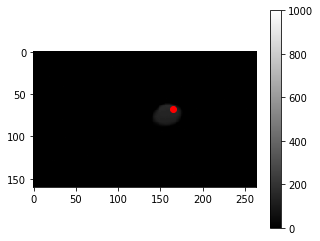

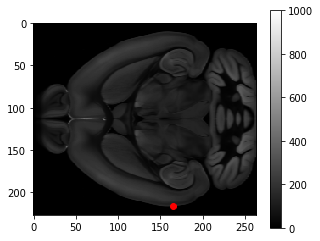

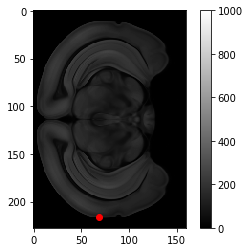

In [194]:
plot_landmark_ortho(atlas, pt, 1000)

In [32]:
pt2 = rfid_r[-1]/0.04128
pt2 = [int(i) for i in pt2]

In [33]:
pt2

[194, 78, 264]

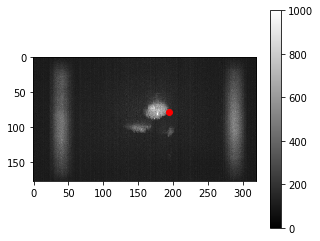

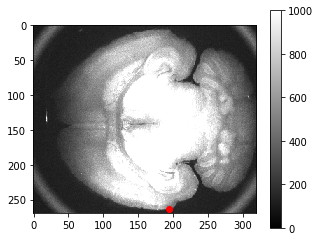

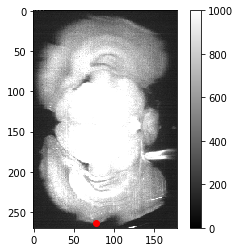

In [35]:
plot_landmark_ortho(ndreg.imgReorient(img,"LPS","ASR"), pt2, 1000)

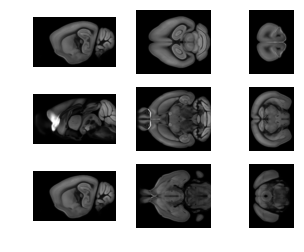

In [190]:
ndreg.imgShow(atlas)

## create annotation image that contains fiducial locations in raw space

## convert fiducials to raw data space

In [139]:
rfid_v = rfid / 0.00516

In [137]:
rfid_idx = np.zeros(rfid_v.shape)
for i in range(rfid_v.shape[0]):
    rfid_idx[i] = np.array([int(j) for j in rfid_v[i]])

# parse viz link points

In [24]:
import json
import re
def get_points_from_viz_link(link, layer):
    link_t = link[link.index('!')+1:]
    link_tr = link_t.replace("_", ",")
    link_tr = link_tr.replace("\'","\"")
    lj = json.loads(link_tr)
    vox_size = np.array(lj['navigation']['pose']['position']['voxelSize']) / 1.0e6 # convert nm to mm
    points = np.array(lj['layers'][layer]['points'])
    return {'points': points, 'vox_size': vox_size}

def add_points_layer_to_viz_link(link, layer, points=[[]]):
    link_t = link[link.index('!')+1:]
    link_tr = link_t.replace("_", ",")
    link_tr = link_tr.replace("\'","\"")
    lj = json.loads(link_tr)
    lj['layers'][layer] = {'type':'pointAnnotation', 'points':points}
    # fix some commas that need to be underscores
    for i in lj['layers'].keys():
        try:
            tmp = lj['layers'][i]['source']
            idx = tmp.index('?')
            lj['layers'][i]['source'] = tmp[:idx].replace(",","_") + tmp[idx:]
        except Exception as e:
            pass
#             print(e.message)
    return link[:link.index('!')+1] + json.dumps(lj)
    

In [32]:
link = "https://viz.boss.neurodata.io/#!{'layers':{'Ch1':{'type':'image'_'source':'boss://https://api.boss.neurodata.io/ailey-dev/Thy1eYFP_Control_9_upload20170919/Ch1?window=0,10000'_'opacity':0.5_'color':1}}_'navigation':{'pose':{'position':{'voxelSize':[5160_5160_5160]_'voxelCoordinates':[1080_1280_712.5]}}_'zoomFactor':5160}}"
layer = 'fiducials'

In [33]:
pts = rfid / 0.00516

In [35]:
add_points_layer_to_viz_link(link, layer, points=pts.tolist())

'https://viz.boss.neurodata.io/#!{"layers": {"Ch1": {"opacity": 0.5, "source": "boss://https://api.boss.neurodata.io/ailey-dev/Thy1eYFP_Control_9_upload20170919/Ch1?window=0,10000", "type": "image", "color": 1}, "fiducials": {"points": [[1022.32, 1622.82, 1078.88], [1022.32, 693.611, 866.1690000000001], [625.031, 1337.93, 419.318], [1379.04, 1250.46, 407.306], [1042.33, 2020.68, 307.306], [1731.33, 1535.37, 727.533], [365.663, 1565.31, 743.58], [1005.74, 697.152, 860.371], [748.991, 681.94, 1188.46], [1269.71, 686.929, 1201.32], [851.266, 1938.83, 212.996], [1242.22, 1950.14, 196.114], [757.877, 503.5, 1022.65], [1251.74, 483.49999999999994, 1059.4], [1222.42, 593.5, 1164.7], [792.597, 623.5, 1158.15], [1051.93, 663.5, 841.3], [939.623, 673.5, 852.7899999999998], [1364.93, 613.5, 885.9289999999999], [707.795, 663.5, 864.947], [1006.82, 933.4999999999999, 1064.06], [869.254, 976.332, 534.122], [1190.24, 979.321, 511.12699999999995], [1058.45, 1059.32, 527.198], [968.455, 1059.32, 530.41

In [74]:
def plot_landmark_ortho(img, pt, refThreshold):
    test_img = sitk.GetArrayViewFromImage(img[:,:,pt[2]]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[0], pt[1], 'ro')
    plt.colorbar()
    plt.show()
    test_img = sitk.GetArrayViewFromImage(img[:,pt[1],:]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[0], pt[2], 'ro')
    plt.colorbar()
    plt.show()
    test_img = sitk.GetArrayViewFromImage(img[pt[0],:,:]).astype('uint16')
    plt.imshow(test_img, vmax=refThreshold, cmap='gray')
    plt.plot(pt[1], pt[2], 'ro')
    plt.colorbar()
    plt.show()

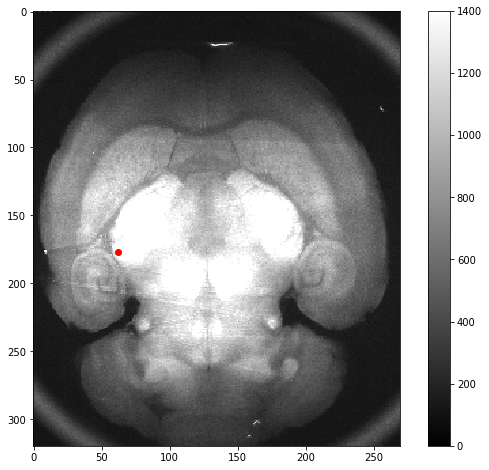

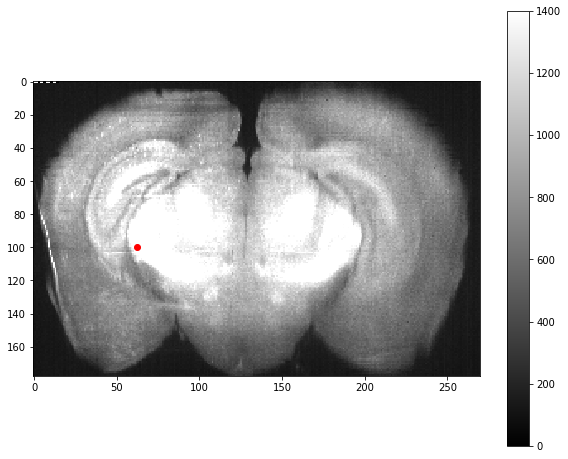

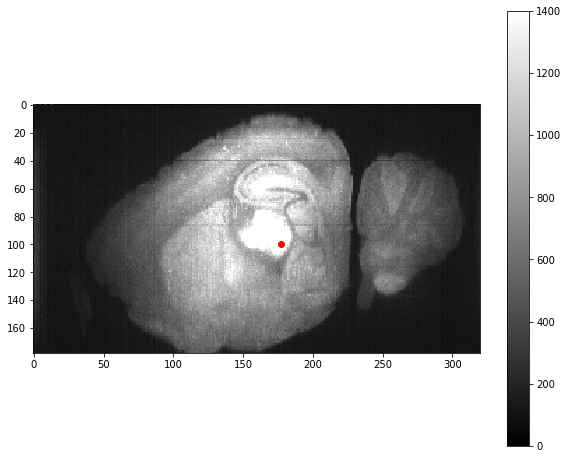

In [77]:
plot_landmark_ortho(inImg_orig, point_i, 1400)

In [ ]:
ndreg.imgMetamorphosisComposite()